In [ ]:
 from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/rainfall/201807_202306/events

Mounted at /content/drive
/content/drive/MyDrive/rainfall/201807_202306/events


## Plot all rainfall events for dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText

<ipython-input-3-328152ffe095>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_5min = df.resample('5T').sum()
<ipython-input-3-328152ffe095>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_5min = df.resample('5T').sum()
<ipython-input-3-328152ffe095>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_5min = df.resample('5T').sum()
<ipython-input-3-328152ffe095>:20: FutureWarning: The default value of numeric_

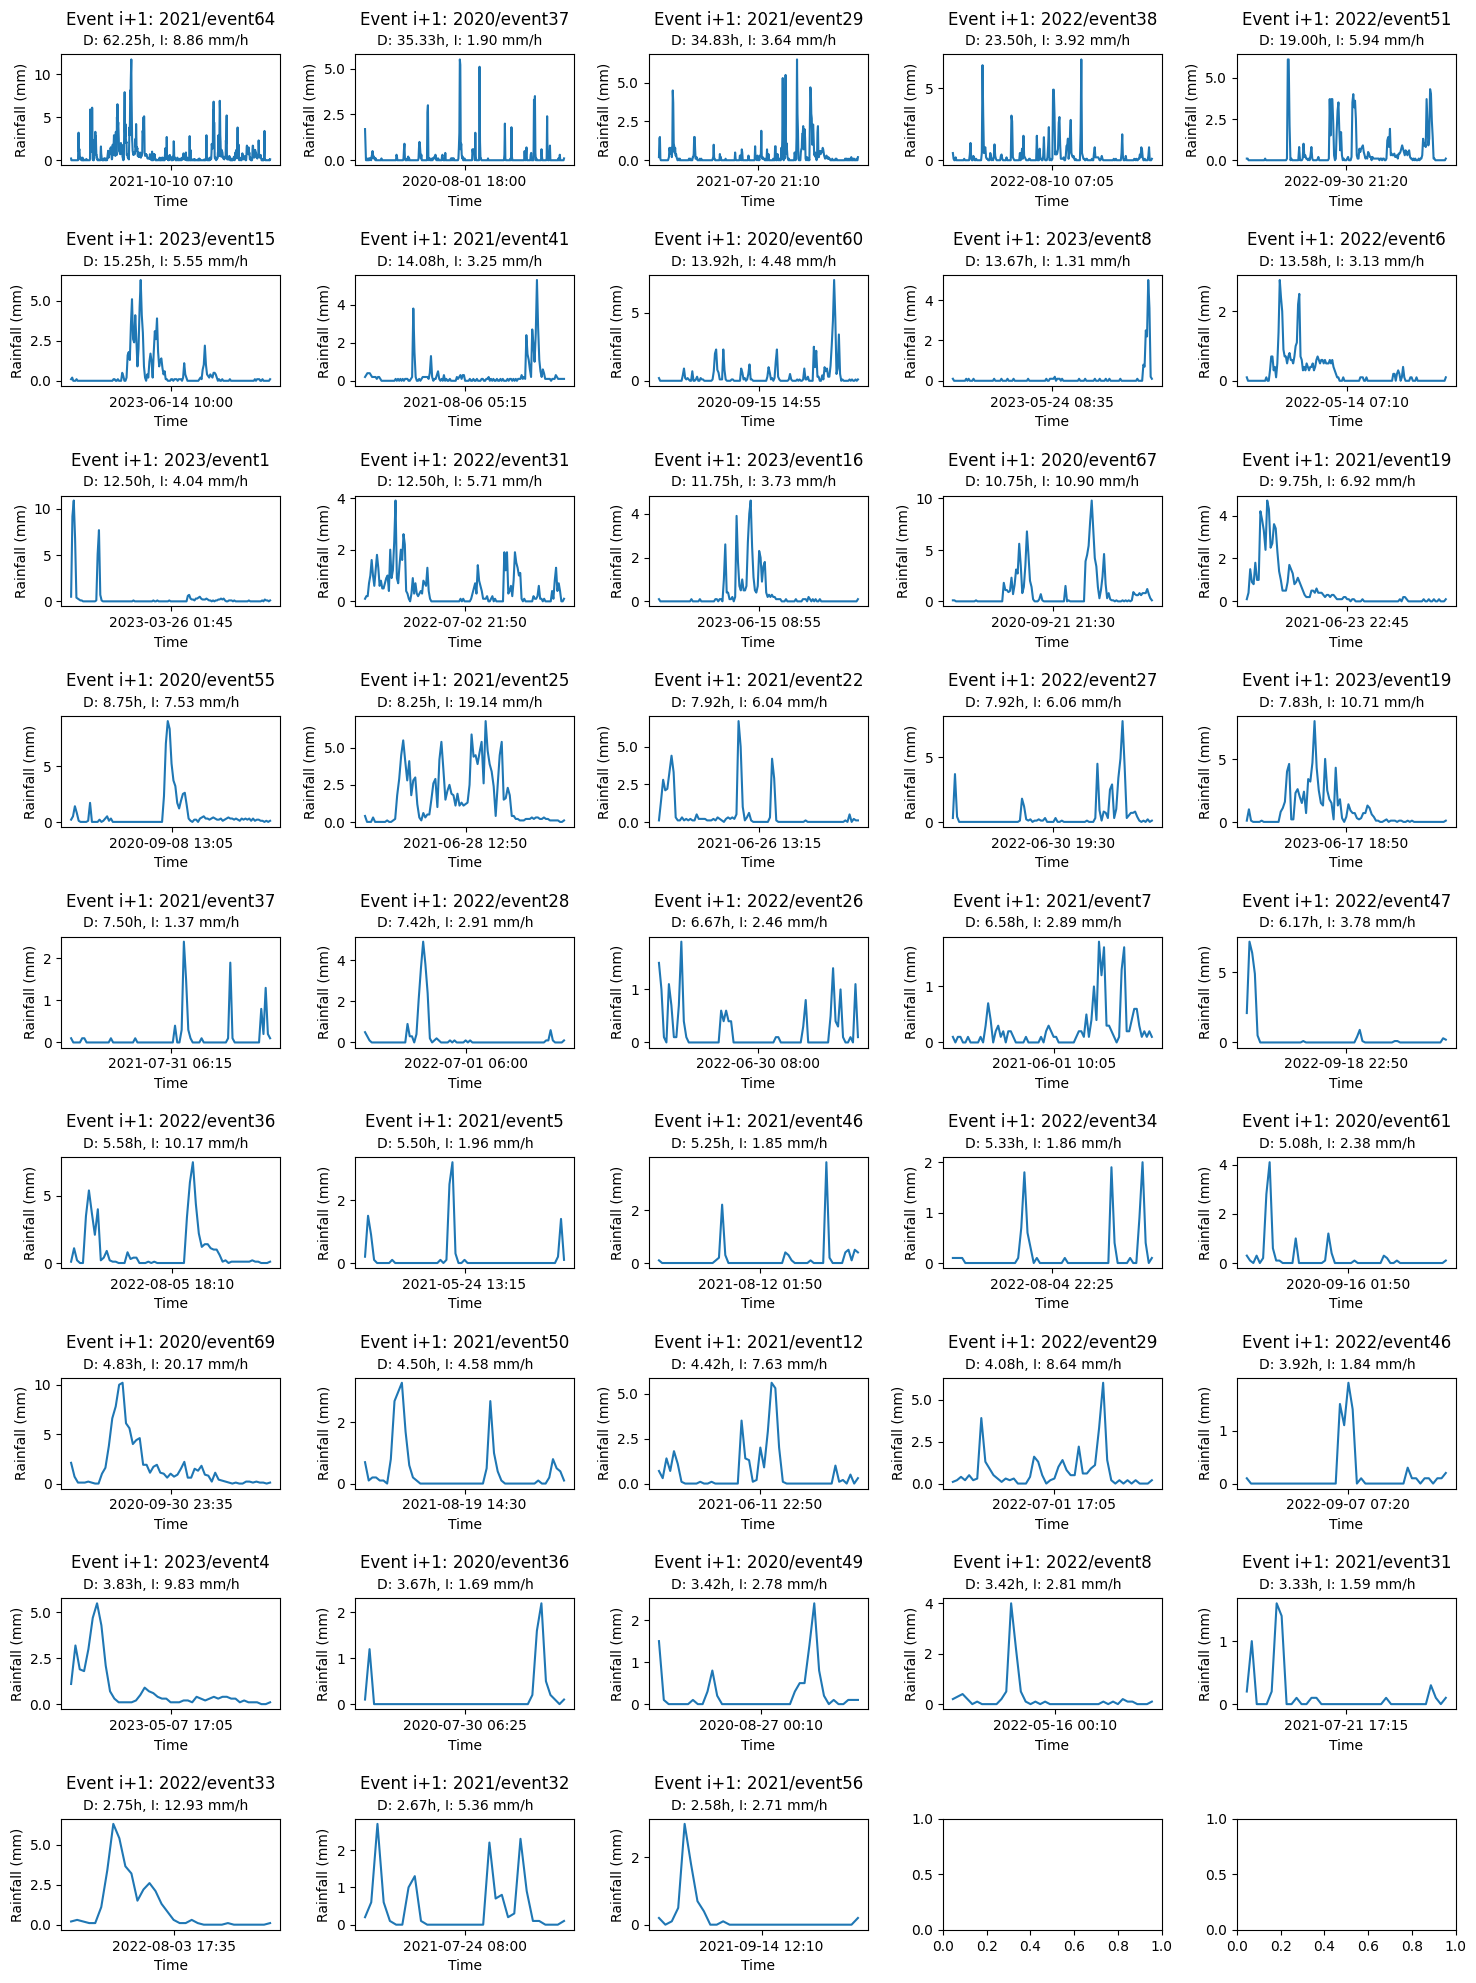

In [ ]:
# file names extracted by 2_IETD_Inter-Event Time Definition
file_names = ['2021/event64','2020/event37','2021/event29','2022/event38','2022/event51','2023/event15','2021/event41',
              '2020/event60','2023/event8','2022/event6','2023/event1','2022/event31','2023/event16','2020/event67',
              '2021/event19','2020/event55','2021/event25','2021/event22','2022/event27','2023/event19','2021/event37',
              '2022/event28','2022/event26','2021/event7','2022/event47','2022/event36','2021/event5','2021/event46',
              '2022/event34','2020/event61','2020/event69','2021/event50','2021/event12','2022/event29','2022/event46',
              '2023/event4','2020/event36','2020/event49','2022/event8','2021/event31','2022/event33','2021/event32',
              '2021/event56']

fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(15, 20))
# plot all rainfall events
for i, file in enumerate(file_names):
    df = pd.read_csv(file + '.csv')
    df['datetime'] = pd.to_datetime(df['DateAndTime'])
    df.set_index('datetime', inplace=True)
    df_5min = df.resample('5T').sum()
    row = i // 5
    col = i % 5
    axs[row, col].plot(df_5min.index, df_5min['rainfall'])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Rainfall (mm)')
    axs[row, col].set_title('Event i+1: '+ file, y = 1.2)
    duration = (df_5min.index[-1] - df_5min.index[0]).total_seconds() / 3600  # calculate duration in hours
    accumulation = df_5min['rainfall'].sum()  # calculate accumulation
    intensity = accumulation / duration # calculate intensity (mm/hour)
    axs[row, col].text(0.1, 1.12, f'D: {duration:.2f}h, I: {intensity:.2f} mm/h', transform=axs[row, col].transAxes, fontsize=10, verticalalignment='center')
    # Set x-axis ticks and labels to show only the start value
    #axs[row, col].set_xticks([df_5min.index[-1]])
    axs[row, col].set_xticks([df_5min.index[len(df_5min.index) // 2]])
    axs[row, col].set_xticklabels([df_5min.index[-1].strftime('%Y-%m-%d %H:%M')])

plt.tight_layout()
plt.show()


##SWMM Simulation

In [ ]:
!pip install swmm-api
!pip install pyswmm

In [ ]:
from swmm_api import read_inp_file
from swmm_api import read_out_file
from swmm_api import swmm5_run
from swmm_api.input_file.sections import RainGage
from swmm_api.input_file.sections import OptionSection
import pandas as pd
import datetime
import numpy as np
import os

In [ ]:
file_names = ['2021/event64','2020/event37','2021/event29','2022/event38','2022/event51','2023/event15','2021/event41',
              '2020/event60','2023/event8','2022/event6','2023/event1','2022/event31','2023/event16','2020/event67',
              '2021/event19','2020/event55','2021/event25','2021/event22','2022/event27','2023/event19','2021/event37',
              '2022/event28','2022/event26','2021/event7','2022/event47','2022/event36','2021/event5','2021/event46',
              '2022/event34','2020/event61','2020/event69','2021/event50','2021/event12','2022/event29','2022/event46',
              '2023/event4','2020/event36','2020/event49','2022/event8','2021/event31','2022/event33','2021/event32',
              '2021/event56']

for file in file_names:
    df = pd.read_csv(file + '.csv')
    df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
    df = df.assign(
        year=df["DateAndTime"].dt.year,
        month=df["DateAndTime"].dt.month,
        day=df["DateAndTime"].dt.day,
        hour=df["DateAndTime"].dt.hour,
        minute=df["DateAndTime"].dt.minute,
        date = df["DateAndTime"].dt.date,
        time = df["DateAndTime"].dt.time,
    )
    df["station"]="STA01"
    newdf = pd.DataFrame(df[['station', 'year', 'month', 'day', 'hour', 'minute','rainfall']])
    newdf.to_csv(file + '.dat', sep = "\t",index=None,header=None)

    # set start and end time
    start_datetime = df['DateAndTime'].iloc[0] - datetime.timedelta(minutes=60)
    start_date = start_datetime.date()
    strat_time = start_datetime.time()
    end_date = df['date'].iloc[-1]
    end_time = df['time'].iloc[-1]


    # creat an inp. file in SWMM software with network data, 3 year climate data as a baseline
    # read this inp file, only change rainfall for following simulations
    inp = read_inp_file('in_8.9.inp')


    # edit raingage and change rainfall files
    inp.RAINGAGES['STA01'] = RainGage(name='STA01', form='VOLUME', interval='0:01', SCF=1.0, source='FILE', filename='/content/drive/MyDrive/rainfall/201807_202306/events/'+ file + '.dat',  station='STA01', units='MM')


    # edit running options and change time
    inp.OPTIONS['START_DATE'] = start_date
    inp.OPTIONS['START_TIME'] = strat_time
    inp.OPTIONS['REPORT_START_DATE'] = start_date
    inp.OPTIONS['REPORT_START_TIME'] = strat_time
    inp.OPTIONS['END_DATE'] = end_date
    inp.OPTIONS['END_TIME'] = end_time
    print(inp.OPTIONS.to_inp_lines())


    #write to a new inp file and run it
    inp.write_file(file + '.inp')
    swmm5_run('/content/drive/MyDrive/rainfall/201807_202306/events/'+ file +'.inp', progress_size=100)


## Generate Training Data

In [ ]:
def generate_data(raindata_masked, seq_length_x, seq_length_y, y_start):
    df_data = raindata_masked.iloc[:,1:]
    df_rain = raindata_masked.iloc[:,:1]
    num_samples, num_nodes = df_data.shape
    data = np.expand_dims(df_data.values, axis=-1)
    feature_list = [data]
    rain = df_rain.iloc[:,0]
    rainfall = np.tile(rain, [1, num_nodes, 1]).transpose((2, 1, 0))
    feature_list.append(rainfall)
    data = np.concatenate(feature_list, axis=-1)
    x, y = [], []
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))
    for t in range(min_t, max_t):
        x.append(data[t + x_offsets, ...])
        y.append(data[t + y_offsets, ...])
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y

In [ ]:
def concat_shuffle_writeintonpz_data(outx, outy, save_dir):
    x_con = np.concatenate(outx, axis=0)
    y_con = np.concatenate(outy, axis=0)
    permutation = np.random.permutation(x_con.shape[0])
    x_data = x_con[permutation]
    y_data = y_con[permutation]
    num_samples = x_data.shape[0]
    num_val = round(num_samples * 0.15)
    num_train = round(num_samples * 0.7)
    #num_test = round(num_samples * 0.15)# the number of test sample should be the same for different input length, so we dont use this line
    num_test = round(599) # this line assign same number of test sample for all input length, 599 is the test sample created by the largest input length, which is a minimum
    x_train, y_train = x_data[:num_train], y_data[:num_train]
    x_val, y_val = (
        x_data[num_train: num_train + num_val],
        y_data[num_train: num_train + num_val],
    )
    x_test, y_test = x_data[-num_test:], y_data[-num_test:]
    for cat in ["train", "val", "test"]:
        _x, _y = locals()["x_" + cat], locals()["y_" + cat]
        print(cat, "x:", _x.shape, "y:", _y.shape)
        file_path = os.path.join(save_dir, f"{cat}.npz")
        np.savez_compressed(
            file_path,
            x=_x,
            y=_y,
            x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
            y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
        )

In [ ]:
seq_lengths = [(6, 6), (7, 6), (8, 6), (9, 6),(10, 6), (11, 6),(12, 6), (13, 6),(14, 6)]

for seq_length_x, seq_length_y in seq_lengths:
    y_start = 1
    x_offsets = np.sort(np.concatenate((np.arange(-(seq_length_x - 1), 1, 1),)))
    y_offsets = np.sort(np.arange(y_start, (seq_length_y + 1), 1))

    save_dir_link = "/content/drive/MyDrive/0809/link/"+"link_flow_len" + str(seq_length_x) +"_" + str(seq_length_y) +"_f_r"
    save_dir_node = "/content/drive/MyDrive/0809/node/"+"node_flow_len" + str(seq_length_x) +"_" + str(seq_length_y) +"_f_r"
    save_dir_cap = "/content/drive/MyDrive/0809/cap/"+"link_cap_len" + str(seq_length_x) +"_" + str(seq_length_y) +"_f_r"
    os.makedirs(save_dir_link)
    os.makedirs(save_dir_node)
    os.makedirs(save_dir_cap)

    outx_node=[]
    outy_node=[]
    outx_link=[]
    outy_link=[]
    outx_cap=[]
    outy_cap=[]

    file_names = ['2021/event64','2020/event37','2021/event29','2022/event38','2022/event51','2023/event15','2021/event41',
                  '2020/event60','2023/event8','2022/event6','2023/event1','2022/event31','2023/event16','2020/event67',
                  '2021/event19','2020/event55','2021/event25','2021/event22','2022/event27','2023/event19','2021/event37',
                  '2022/event28','2022/event26','2021/event7','2022/event47','2022/event36','2021/event5','2021/event46',
                  '2022/event34','2020/event61','2020/event69','2021/event50','2021/event12','2022/event29','2022/event46',
                  '2023/event4','2020/event36','2020/event49','2022/event8','2021/event31','2022/event33','2021/event32',
                  '2021/event56']

    for file in file_names:
    # read out file
        out = read_out_file('/content/drive/MyDrive/rainfall/201807_202306/events/'+file +'.out')
        type(out.to_numpy())
        out.to_frame()

    # extract rainfall, node, link,cap and concat them
        rainfall = out.get_part('system', '', 'rainfall')
        node = out.get_part('node',out.labels['node'],'total_inflow')
        link = out.get_part('link',out.labels['link'],'flow')
        cap = out.get_part('link',out.labels['link'],'capacity')
        rainnode = pd.concat([rainfall, node], axis=1)
        rainlink = pd.concat([rainfall, link], axis=1)
        raincap = pd.concat([rainfall, cap], axis=1)

    # make two masks to drop flow = 0 at start and rainfall = 0 at the end
        masknode = (rainnode.iloc[:, 1:2] == 0).all(axis=1)
        start = masknode.loc[~masknode].index[0]
        maskrain = (rainnode.iloc[:, 0:1] == 0).all(axis=1)
        end = maskrain.loc[~maskrain].index[-1]
        mask = (rainnode.index < start) | (rainnode.index > end)
        rainnode_masked = rainnode.loc[~mask]
        rainlink_masked = rainlink.loc[~mask]
        raincap_masked = raincap.loc[~mask]

    # process and append data
        rainnode_x, rainnode_y = generate_data(rainnode_masked, seq_length_x, seq_length_y, y_start)
        rainlink_x, rainlink_y = generate_data(rainlink_masked, seq_length_x, seq_length_y, y_start)
        raincap_x, raincap_y = generate_data(raincap_masked, seq_length_x, seq_length_y, y_start)
        outx_node.append(rainnode_x)
        outy_node.append(rainnode_y)
        outx_link.append(rainlink_x)
        outy_link.append(rainlink_y)
        outx_cap.append(raincap_x)
        outy_cap.append(raincap_y)

    concat_shuffle_writeintonpz_data(outx_node, outy_node, save_dir_node)
    concat_shuffle_writeintonpz_data(outx_link, outy_link, save_dir_link)
    concat_shuffle_writeintonpz_data(outx_cap, outy_cap, save_dir_cap)

train x: (2997, 7, 664, 2) y: (2997, 6, 664, 2)
val x: (642, 7, 664, 2) y: (642, 6, 664, 2)
test x: (599, 7, 664, 2) y: (599, 6, 664, 2)
train x: (2997, 7, 667, 2) y: (2997, 6, 667, 2)
val x: (642, 7, 667, 2) y: (642, 6, 667, 2)
test x: (599, 7, 667, 2) y: (599, 6, 667, 2)
train x: (2997, 7, 667, 2) y: (2997, 6, 667, 2)
val x: (642, 7, 667, 2) y: (642, 6, 667, 2)
test x: (599, 7, 667, 2) y: (599, 6, 667, 2)
train x: (3027, 6, 664, 2) y: (3027, 6, 664, 2)
val x: (649, 6, 664, 2) y: (649, 6, 664, 2)
test x: (599, 6, 664, 2) y: (599, 6, 664, 2)
train x: (3027, 6, 667, 2) y: (3027, 6, 667, 2)
val x: (649, 6, 667, 2) y: (649, 6, 667, 2)
test x: (599, 6, 667, 2) y: (599, 6, 667, 2)
train x: (3027, 6, 667, 2) y: (3027, 6, 667, 2)
val x: (649, 6, 667, 2) y: (649, 6, 667, 2)
test x: (599, 6, 667, 2) y: (599, 6, 667, 2)
train x: (2816, 14, 664, 2) y: (2816, 5, 664, 2)
val x: (603, 14, 664, 2) y: (603, 5, 664, 2)
test x: (599, 14, 664, 2) y: (599, 5, 664, 2)
train x: (2816, 14, 667, 2) y: (2816, 